# Multifractal analysis of GOES-16 Outgoing Longwave Radiation

## imports and definitions

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

from scipy.optimize import curve_fit

from multifractalanalysis import multifractals

In [2]:
## INTERPOLATION PLOTS
def _colorbar_axis(ax, x=1.05, y=0, w="2%"):
    """
    Uses inset_axes to add a vertical colorbar to the right of your plot
    """
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(ax, width=w,height="100%",
                       loc='lower left',bbox_to_anchor=(x, y, 1, 1),
                       bbox_transform=ax.transAxes,borderpad=0)
    return axins

def plot_interpolation(ax, interp, label, cb=True, extent=[-130, -20, -30, 30], cbar_label=r'OLR [W/m$^2$]', cmap='Blues', vmin=None, vmax=None):
    ax.coastlines()
    im = ax.imshow(interp, cmap=cmap, extent=extent, vmin=vmin, vmax=vmax)
    if cb:
        cbar = plt.colorbar(im, cax=_colorbar_axis(ax))
        cbar.set_label(cbar_label)
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')

## PLOT STRUCTURE FUNCTIONS
def plot_moms(moments, R, Q, ax, txt, pxres=0.05, fittingRange=(2.5, 5), colours=None):
    if not colours: colours = sns.color_palette("flare", n_colors=10)
    R = R * pxres * 111 # 0.05 degrees, 1 degree approx = 111km, 1km = 1e3m
    
    axs = [ax for i in range(10)]

    for q, ax, col in zip(Q, axs, colours):
        # normalise the qth moment for simpler plotting
        normQthMoment = moments[:, q-1] / moments[0, q-1]
        ax.plot(R, normQthMoment, color=col, label=f'q = {q:.0f}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylabel(r'$S_q (r) / S_q (1)$')

    ylims = ax.get_ylim()

    ax.fill_between(R, 0, ylims[1], where = (R > np.exp(fittingRange[0]) * pxres * 111 ) & (R < np.exp(fittingRange[1]) * pxres * 111),
                    facecolor='steelblue', alpha=0.1)
    
    ax.text(1e2, 8e3, 'fitting range', fontsize=8, weight='bold', color='steelblue')
   
    ax.set_ylim(1, ylims[1])
    ax.set_xlabel('r (km)')



## ZETA PLOTS AND FITTING
def ZetaFunc(q, a, zeta_inf):
    zeta_q = a * q / (1 + a * q / zeta_inf)
    return zeta_q

def axZetaPlot(qq, zetas, par, ax, label, color, showpar=True, yerr=None):
    if showpar: ax.plot(qq, zetas, 'o', color=color, label=label + fr' (a={par[0]:.2f}, $\zeta_\infty$={par[1]:.2f})', zorder=2)
    else: ax.plot(qq, zetas, 'o', color=color, label=label, zorder=2)
    ax.plot(qq, ZetaFunc(qq, par[0], par[1]), '-', color='grey', zorder=1)
    ax.set_xlabel('q')
    ax.set_ylabel(r'$\zeta_q$')


## load file

In [3]:
goes_olr = np.loadtxt('/work/bb1153/b382145/GOES-16/Work_G16/olr_0-05deg/nearest-neighbour/olr_s20202450000201.txt')

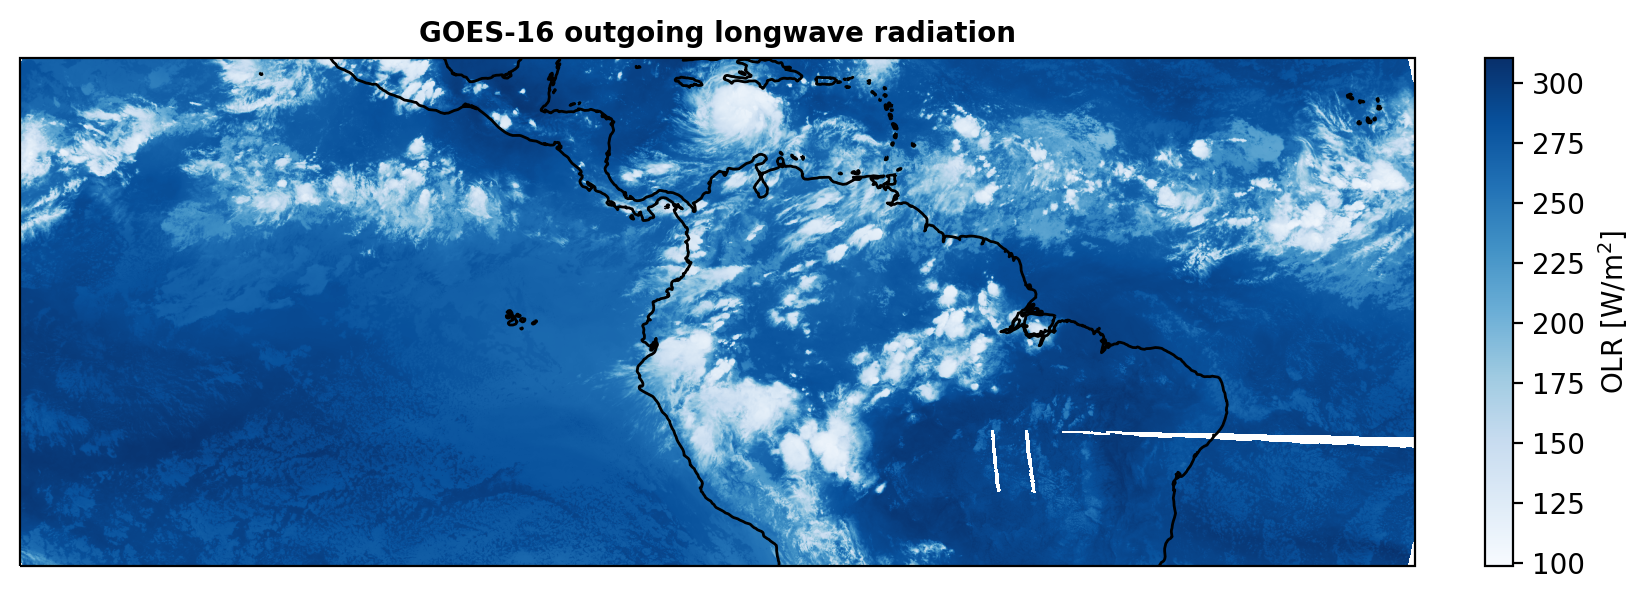

In [4]:
fig, ax = plt.subplots(1,1, figsize=(9,5), dpi=200, subplot_kw={'projection':ccrs.PlateCarree()})
plot_interpolation(ax, goes_olr[200:-200], 'GOES-16', extent=[-130, -20, -20, 20])
ax.set_title('GOES-16 outgoing longwave radiation', weight='bold', size=10)
plt.show()

## compute and plot structure functions and scaling exponents

In [5]:
R = np.array([2**x for x in range(0, 10)])
Q = np.arange(0, 11)
moments, zetas =  multifractals(goes_olr[200:-200], R, Q)

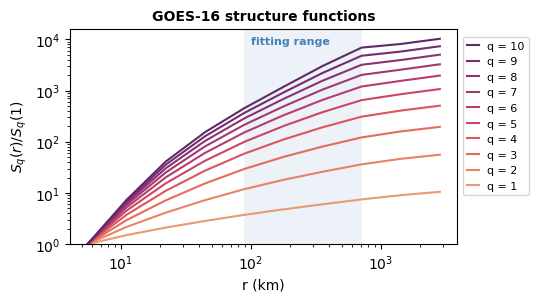

In [6]:
fig, ax = plt.subplots(1,1, figsize=[5,2.8])
plot_moms(moments[:,1:], R, Q[1:], ax, 'GOES-16', pxres=0.05, fittingRange=(2.5, 5))
plt.title('GOES-16 structure functions', weight='bold', size=10)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=4, fontsize=8, handlelength=1, bbox_to_anchor=(1.2, 0.2))
plt.show()

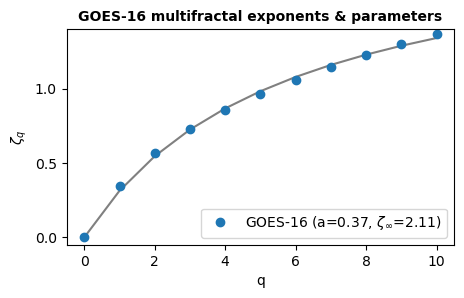

In [7]:
fig, ax = plt.subplots(1,1, figsize=[5,2.8])

# compute parameters a and zeta_infinity for GOES-16
goes_par, _ = curve_fit(ZetaFunc, Q, zetas)

# plot the scaling exponents and the fitted curve
axZetaPlot(Q, zetas, goes_par, ax, 'GOES-16', 'tab:blue')

plt.yticks(np.arange(0,1.6,0.5))
plt.ylim([-0.05, 1.4])
plt.legend(loc=4)
plt.title('GOES-16 multifractal exponents & parameters', weight='bold', size=10)
plt.show()